In [41]:
%pwd

'C:\\Users'

In [43]:
%ls "Richard Guinto\\msee\\dataset\\test"

 Volume in drive C has no label.
 Volume Serial Number is 4A9E-AED8

 Directory of C:\Users\Richard Guinto\msee\dataset\test

10/22/2017  07:14 PM    <DIR>          .
10/22/2017  07:14 PM    <DIR>          ..
10/22/2017  07:14 PM             6,148 .DS_Store
10/22/2017  07:14 PM       302,580,104 f7823b11-901a-457a-89a2-8c37dc4fef60.npz
10/22/2017  07:14 PM       302,580,104 fa6716a8-218c-42b1-a6aa-3fd014eb0f64.npz
10/22/2017  07:14 PM       302,580,104 faf48514-698b-45e3-ae58-60c9189e0426.npz
               4 File(s)    907,746,460 bytes
               2 Dir(s)  687,024,029,696 bytes free


In [39]:
%matplotlib inline

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import glob

path = "Richard Guinto/msee/dataset/test/f7823b11-901a-457a-89a2-8c37dc4fef60.npz"
print('path:', os.path.abspath(path))

archive = np.load(os.path.abspath(path))
print('keys:', archive.files)

path: C:\Users\Richard Guinto\msee\dataset\test\f7823b11-901a-457a-89a2-8c37dc4fef60.npz
keys: ['images', 'offsets']


In [44]:
images = archive['images']
offsets = archive['offsets']

print('images.shape: ', images.shape)
print('offsets.shape: ', offsets.shape)

images.shape:  (9216, 128, 128, 2)
offsets.shape:  (9216, 8)


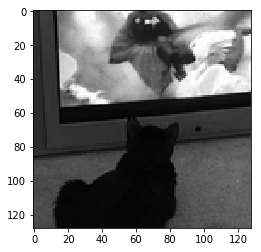

In [48]:
sample_image = np.split(images[0], 2, axis=-1)
plt.imshow(sample_image[0].squeeze(), cmap='gray')

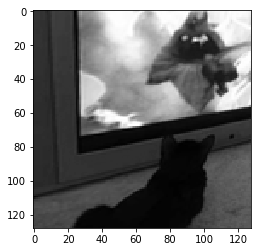

In [49]:
plt.imshow(sample_image[1].squeeze(), cmap='gray')

In [50]:
sample_offset = offsets[0]
print('sample offset: ', sample_offset)

sample offset:  [ -4  -6 -29 -12  -3 -23  -2  24]
